# Simulations

This notebook is used to run simulations on an environment. The reason why we do it in an notebook is because we can reuse calculated policies. As calculating policies with policiy iteration can take time, this safes time and resources.

## 1. Running simulations for crossing env with optimal policy

### 1.1 Load environments and create envs

In [3]:
from envs.loader import load_config, create_wrapped_env_from_config
from probabilistic_minigrids import ProbabilisticEnvWrapper


crossing_config = load_config("./envs/configs/goal_state/CrossingEnv.yaml")
crossing_env_prob = create_wrapped_env_from_config(crossing_config)

crossing_env_storm_model, _ = crossing_env_prob.convert_to_probabilistic_storm()

### 1.2 Find optimal policy

In [ ]:
from utils.utils import custom_policy_iteration

goal_maximization = "Pmax=? [F \"goal\"]"

print("Running policy iteration...")
result, scheduler = custom_policy_iteration(crossing_env_prob.model, prop=goal_maximization, visualize=False)


Running policy iteration...


### 1.3 Run simulation

### Without Delta Shield

In [5]:
from simulations import run_simulation



reach_goal_baseline, reach_lava_baseline, reach_truncated_baseline = run_simulation(crossing_env_prob, scheduler, num_episodes=1000)
print(f"reach_goal:{reach_goal_baseline}, reach_lava:{reach_lava_baseline}, reach_truncated:{reach_truncated_baseline}")

reach_goal:915, reach_lava:85, reach_truncated:0


### With Delta Shield

WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
DEBUG: Shield blocked 0 actions and validated 51069
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
DEBUG: Shield blocked 0 actions and validated 51584
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized for scheduler extraction. Initializing now, but this is inefficient.
WARN  (IterativeMinMaxLinearEquationSolver.cpp:191): Expected VI operator to be initialized

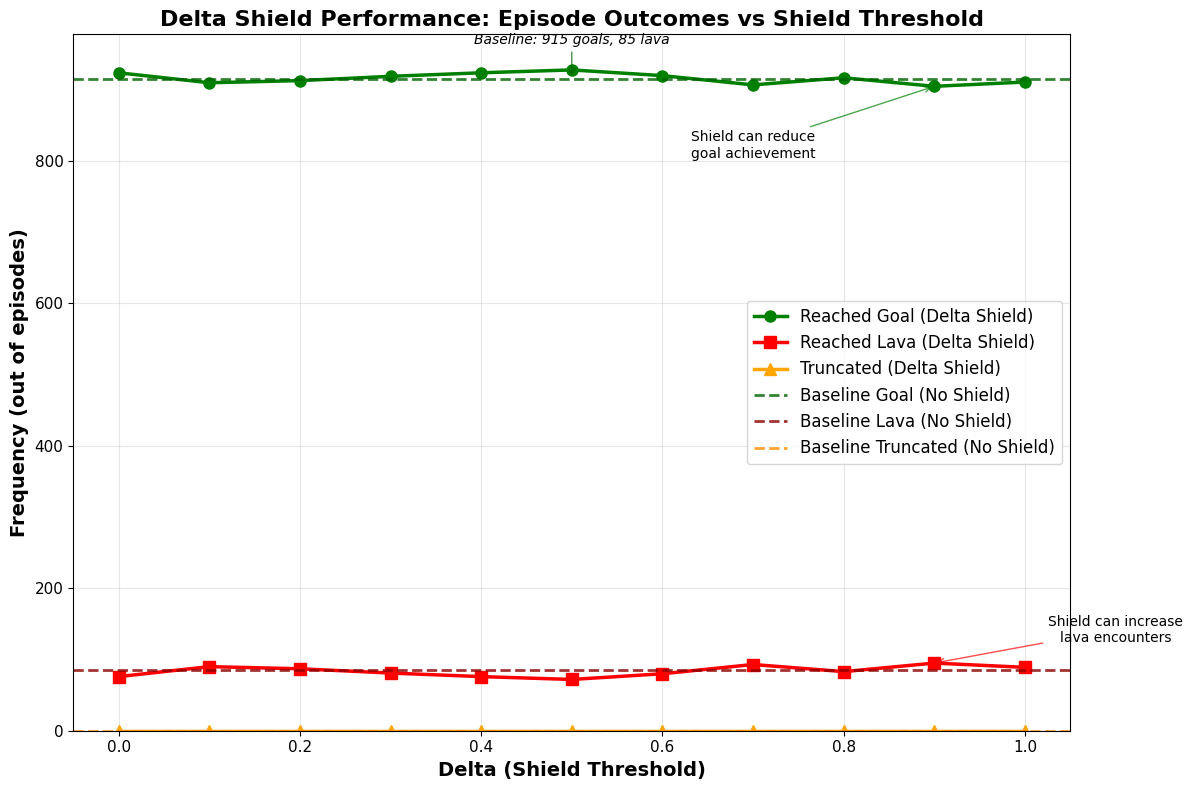

Delta Shield Performance Summary:
BASELINE (No Shield): 915 goals, 85 lava, 0 truncated

DELTA SHIELD RESULTS:
Best goal achievement: 928 episodes at delta = 0.5
Worst lava encounters: 95 episodes at delta = 0.9
Average goal achievement: 916.2 episodes
Average lava encounters: 83.8 episodes

COMPARISON TO BASELINE:
Goal achievement: Baseline = 915, Shield avg = 916.2 (+1.2)
Lava encounters: Baseline = 85, Shield avg = 83.8 (-1.2)


In [ ]:
from shield import DeltaShield
from utils.plotting import plot_delta_shield_performance
deltas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
goal =[]
lava = []
truncated = []


for delta in deltas:
    shield = DeltaShield(crossing_env_storm_model, "Pmin=? [F \"lava\"]", delta=delta)
    reach_goal, reach_lava, reach_truncated = run_simulation(crossing_env_prob, scheduler, shield=shield, num_episodes=1000)
    goal.append(reach_goal)
    lava.append(reach_lava)
    truncated.append(reach_truncated)

plot_delta_shield_performance(
    deltas_list=deltas,
    goal_list=goal, 
    lava_list=lava,
    truncated_list=truncated,
    baseline_goal=reach_goal_baseline, 
    baseline_lava=reach_lava_baseline,
    baseline_truncated=reach_truncated_baseline
)


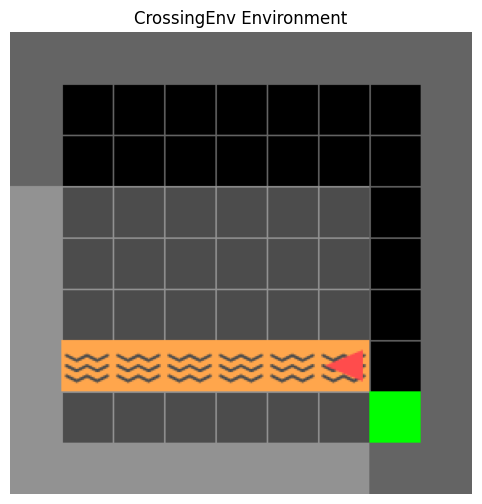

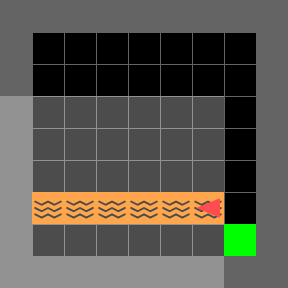

In [6]:
# Quick function to render the environment
def render_env(env):
    """Render the environment and display it as an image"""
    from PIL import Image
    import matplotlib.pyplot as plt
    
    # Get the RGB array from the environment
    rgb_array = env.render()
    
    # Convert to PIL Image and display
    img = Image.fromarray(rgb_array)
    
    # Display using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('CrossingEnv Environment')
    plt.show()
    
    return img

# Render the current environment
render_env(crossing_env_prob)